In [1]:
!pip install -q python-dotenv
import os
from dotenv import load_dotenv
load_dotenv()

!pip install -q pymupdf
import fitz

# print(os.environ['ANTHROPIC_API_KEY'])
!pip install -q anthropic
import anthropic

import time

In [2]:
def pdf_to_text(file, pages=None):
    if pages is None:
        pages = set(range(doc.page_count))
    else:
        assert isinstance(pages, list)
        pages = set(pages)
    with fitz.open(file) as doc:
        text = ""
        for pagei, page in enumerate(doc):
            if pagei in pages:
                text += page.get_text()
        #meta = doc.metadata
    return text

def pdf_to_base64_pngs(pdf_path, quality=75, max_size=(1024, 1024), ext='png', pages=None):
    from PIL import Image
    import io
    import fitz
    import tempfile
    import base64
    from io import BytesIO

    # Open the PDF file
    doc = fitz.open(pdf_path)

    # Iterate through each page of the PDF
    images = []
    if pages is None:
        pages = list(range(doc.page_count))
    else:
        assert isinstance(pages, list)

    for page_num in pages:
        # Load the page
        page = doc.load_page(page_num)

        # Render the page as a PNG image
        pix = page.get_pixmap(matrix=fitz.Matrix(300 / 72, 300 / 72))

        # Save the PNG image
        output_path = f"{tempfile.mkdtemp()}/page_{page_num + 1}.{ext}"
        pix.save(output_path)
        images.append(output_path)
    # Close the PDF document
    doc.close()

    if ext == 'png':
        iformat = 'PNG'
    elif ext in ['jpeg', 'jpg']:
        iformat = 'JPEG'
    else:
        raise ValueError("No such ext=%s" % ext)

    images_files = images.copy()
    images = [Image.open(image) for image in images]
    base64_encoded_pngs = []
    for image in images:
        # Resize the image if it exceeds the maximum size
        if image.size[0] > max_size[0] or image.size[1] > max_size[1]:
            image.thumbnail(max_size, Image.Resampling.LANCZOS)
        image_data = io.BytesIO()
        image.save(image_data, format=iformat, optimize=True, quality=quality)
        image_data.seek(0)
        base64_encoded = base64.b64encode(image_data.getvalue()).decode('utf-8')
        base64_encoded_pngs.append(base64_encoded)

    return base64_encoded_pngs, images_files

We aim to give customers more value from their banking relationship with us. 
Through personalisation and distinct propositions, we look to keep meeting 
the needs of our retail and business customers as they evolve over time.
CommBank app 5.0
The CommBank app is central to our customer approach. With 7.8 million users, it is the #1 banking 
app in Australia – and for many customers, continues to be their preferred channel. Harnessing bank 
data and insights on what customers want from a digital banking experience, app 5.0 provides dynamic 
navigation, more personalisation and further integration with CommSec. It has also been built to enable 
us to deliver more enhancements to customers at a faster pace in the future.
Automatic login
Faster experience by 
securely logging in as 
soon as the app opens.
Quick links
Personalised navigation 
tiles based on customer’s 
in-app behaviour 
(e.g. frequently visited).
App library and 
enhanced search 
Simplified catalogue of 
app features, prod

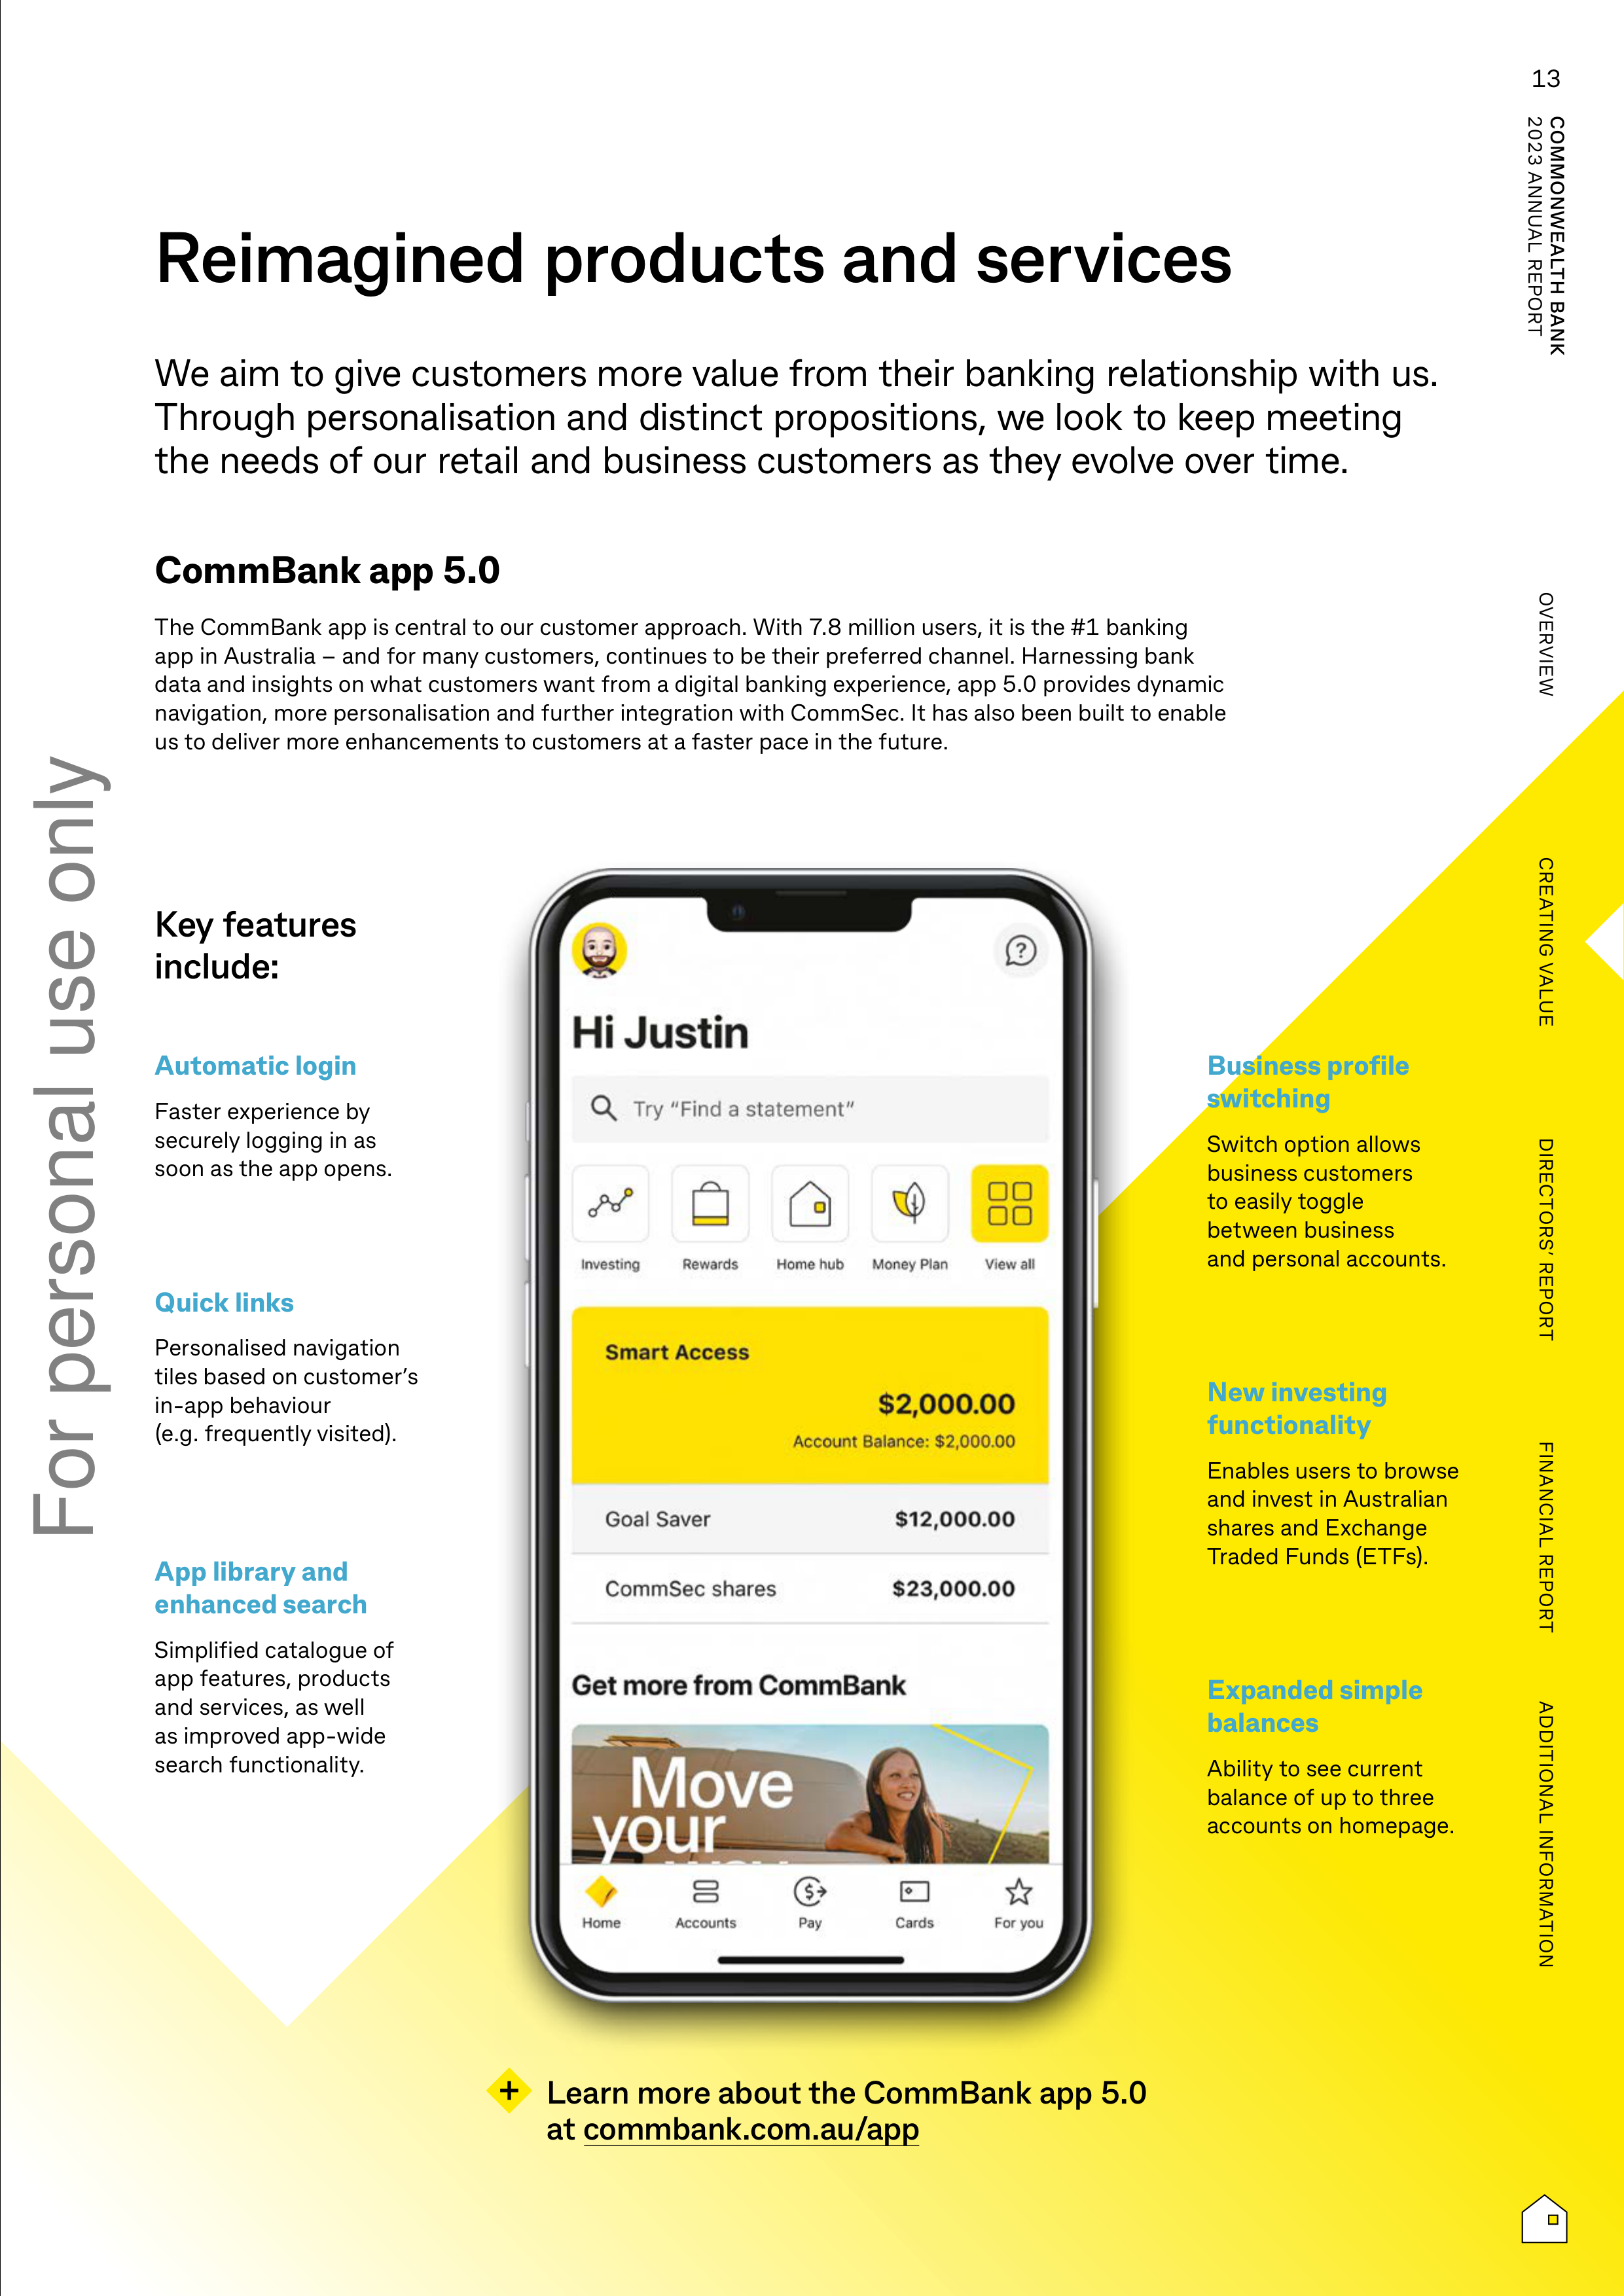

In [3]:
# get pdf
pdf_url = 'https://enterprise-h2ogpt-public-data.s3.amazonaws.com/CBA.2023.Annual.Report.pdf'
pdf_file = os.path.basename(pdf_url)
import requests
with open(pdf_file, 'wb') as f:
    f.write(requests.get(pdf_url).content)

# pdf to text and image
pages = [14]
pdf_text = pdf_to_text(pdf_file, pages=pages)
base64_encoded_pngs, images = pdf_to_base64_pngs(pdf_file, quality=75, max_size=(1024, 1024), ext='png', pages=pages)

# show text
print(pdf_text)

# show page
from IPython.display import Image
Image(filename=images[0], width=400, height=400)

In [16]:
# Define data exraction tool and calculator tool
tools = [
    {
        "name": "save_data",
        "description": "A tool that saves a data about bank balances.",
        "input_schema": {
            "type": "object",
            "properties": {
                "balances": {
                    "description": "The list of balances",
                    "type": "array",
                    "items": {
                    "type": "object",
                    "properties": {
                        "name": {
                        "description": "The name of the transaction or balance",
                        "type": "string"
                        },
                        "amount": {
                        "description": "The amount of the transaction or balance",
                        "type": "number"
                        }
                    }
                    }
                },
                "customer": {
                    "type": "object",
                    "properties": {
                        "name": {
                            "type": "string",
                            "description": "The name of the account holder."
                        },
                        "email": {
                            "type": "string",
                            "format": "email",
                            "description": "The email address of the account holder."
                        }
                    },
                    "required": ["name"]
                },
                "additional_info": {
                    "type": "string",
                    "description": "Additional info about the account or account holder."
                }
            },
            "required": ["balances", "customer"]
        }
    },
    {
        "name": "calculator",
        "description": "A simple calculator that performs basic arithmetic operations.",
        "input_schema": {
            "type": "object",
            "properties": {
                "expression": {
                    "type": "string",
                    "description": "The mathematical expression to evaluate (e.g., '2 + 3 * 4').  Do not include dollar signs or other extra symbols like that."
                }
            },
            "required": ["expression"]
        }
    },
        {
        "name": "plotter",
        "description": "Python code for matplotlib to make a plot.",
        "input_schema": {
            "type": "object",
            "properties": {
                "code": {
                    "type": "string",
                    "description": "Python code for making the matplotlib plot.  Code should be executable with python's exec"
                }
            },
            "required": ["code"]
        }
    }
]

In [17]:
import re

def calculate(expression):
    # Remove any non-digit or non-operator characters from the expression
    # expression = re.sub(r'[^0-9+\-*/().]', '', expression)

    try:
        # Evaluate the expression using the built-in eval() function
        # print("expression: %s" % expression)
        result = eval(expression)
        return str(result)
    except (SyntaxError, ZeroDivisionError, NameError, TypeError, OverflowError):
        return "Error: Invalid expression"

import json
def save_data(tool_input):
    str_result = json.dumps(tool_input)
    with open('customer_data.json', "wt") as f:
        f.write(str_result)
    return str_result

import re

def extract_code_blocks(text):
    # Regular expression to match text between <code> and </code>
    pattern = r'<code>(.*?)</code>'
    # Find all non-overlapping matches and return them as a list
    code_blocks = re.findall(pattern, text, re.DOTALL)
    return code_blocks

def run_code(code_text):
    #code_blocks = extract_code_blocks(code_text)
    #for code in code_blocks:
    #    print(code)
    #    exec(code)
    print("code_text: %s" % code_text)
    try:
        exec(code_text)
    except Exception as e:
        return str(e)
    return code_text

In [28]:
def process_tool_call(tool_name, tool_input):
    if tool_name == "calculator":
        return calculate(tool_input["expression"])
    if tool_name == 'save_data':
        return save_data(tool_input)
    if tool_name == 'plotter':
        return run_code(tool_input['code'])

MODEL_NAME = "claude-3-haiku-20240307"
from anthropic import Anthropic
client = Anthropic()

def chat_with_claude(user_message, user_image=None):
    print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

    messages=[{"role": "user", "content": user_message}]
    if user_image:
        messages[-1]['content'] = [{"type": "image", "source": {"type": "base64", "media_type": "image/png", "data": user_image}},
                                   {"type": "text", "text": messages[-1]['content']},
                                   ]

    response = client.beta.tools.messages.create(
        model=MODEL_NAME,
        max_tokens=4096,
        messages=messages,
        system="You are a data extraction and data plotting assistant.  You have been authorized to extract all textual information from images, because you are working for a bank that has rights to that information.",
        tools=tools,
    )
    messages.append({"role": "assistant", "content": response.content})


    print(f"\nInitial Response:")
    print(f"Stop Reason: {response.stop_reason}")
    print(f"Content: {response.content}")

    while response.stop_reason == "tool_use":
        tool_use = next(block for block in response.content if block.type == "tool_use")
        tool_name = tool_use.name
        tool_input = tool_use.input

        print(f"\nTool Used: {tool_name}")
        print(f"Tool Input: {tool_input}")

        tool_result = process_tool_call(tool_name, tool_input)

        print(f"Tool Result: {tool_result}")

        messages.append({
                    "role": "user",
                    "content": [
                        {
                            "type": "tool_result",
                            "tool_use_id": tool_use.id,
                            "content": str(tool_result),
                        }
                    ],
                })

        response = client.beta.tools.messages.create(
            model=MODEL_NAME,
            max_tokens=4096,
            messages=messages,
            tools=tools,
        )
        messages.append({"role": "assistant", "content": response.content})

    final_response = next(
        (block.text for block in response.content if hasattr(block, "text")),
        None,
    )
    print(response.content)
    print(f"\nFinal Response: {final_response}")

    return final_response

In [29]:
chat_with_claude("What is the result of 1,984,135 * 9,343,116?")


User Message: What is the result of 1,984,135 * 9,343,116?

Initial Response:
Stop Reason: tool_use
Content: [TextBlock(text='Okay, let me use the calculator tool to compute the result of 1,984,135 * 9,343,116:', type='text'), ToolUseBlock(id='toolu_01F2oJSGY9zeM9t5gbdN3xSy', input={'expression': '1984135 * 9343116'}, name='calculator', type='tool_use')]

Tool Used: calculator
Tool Input: {'expression': '1984135 * 9343116'}
Tool Result: 18538003464660
[TextBlock(text='The result of 1,984,135 * 9,343,116 is 18,538,003,464,660.', type='text')]

Final Response: The result of 1,984,135 * 9,343,116 is 18,538,003,464,660.


'The result of 1,984,135 * 9,343,116 is 18,538,003,464,660.'

In [30]:
prompt = f"1) Extract customer data from the text in the document:\n<document>\n{pdf_text}\n</document>.  Do not try to identify people's faces, just extract text.  Do not make up names or amounts.  2) Use the calculator tool to give the average of all their balances that were extracted from the prior tool.  3) Using the balances from the extraction, make a bar chart to show customer balances with names and amounts.  Do not make up amounts."

In [31]:
chat_with_claude(prompt)


User Message: 1) Extract customer data from the text in the document:
<document>
We aim to give customers more value from their banking relationship with us. 
Through personalisation and distinct propositions, we look to keep meeting 
the needs of our retail and business customers as they evolve over time.
CommBank app 5.0
The CommBank app is central to our customer approach. With 7.8 million users, it is the #1 banking 
app in Australia – and for many customers, continues to be their preferred channel. Harnessing bank 
data and insights on what customers want from a digital banking experience, app 5.0 provides dynamic 
navigation, more personalisation and further integration with CommSec. It has also been built to enable 
us to deliver more enhancements to customers at a faster pace in the future.
Automatic login
Faster experience by 
securely logging in as 
soon as the app opens.
Quick links
Personalised navigation 
tiles based on customer’s 
in-app behaviour 
(e.g. frequently visit

'Based on the information provided in the document, I was unable to extract any specific customer data or account balances. The document describes features of the CommBank banking app, but does not provide details about individual customers or their account information.\n\nSince there are no actual account balances to work with, I cannot calculate an average using the calculator tool.\n\nSimilarly, without any real customer data and balances, I cannot create a meaningful bar chart. The document does not contain the necessary information to generate such a visualization.\n\nIn summary, the provided document does not contain the type of customer and account data needed to fulfill the requested tasks. The information is focused on describing the features of the CommBank app rather than providing specific customer financial details.'


User Message: 1) Extract customer data from the textual information on the iphone.  Do not try to identify people's faces, just extract text.  Do not make up names or amounts.  2) Use the calculator tool to give the average of all their balances.  3) Make a bar chart to show customer balances with names and amounts.  Do not make up names or amounts.

Initial Response:
Stop Reason: tool_use
Content: [ToolUseBlock(id='toolu_01GXFsx3hQ3jSHcSFrFwhUvX', input={'customer': {'name': 'Justin', 'email': None}, 'balances': [{'name': 'Smart Access', 'amount': 2000.0}, {'name': 'Goal Saver', 'amount': 12000.0}, {'name': 'CommSec shares', 'amount': 23000.0}], 'additional_info': 'null'}, name='save_data', type='tool_use')]

Tool Used: save_data
Tool Input: {'customer': {'name': 'Justin', 'email': None}, 'balances': [{'name': 'Smart Access', 'amount': 2000.0}, {'name': 'Goal Saver', 'amount': 12000.0}, {'name': 'CommSec shares', 'amount': 23000.0}], 'additional_info': 'null'}
Tool Result: {"customer

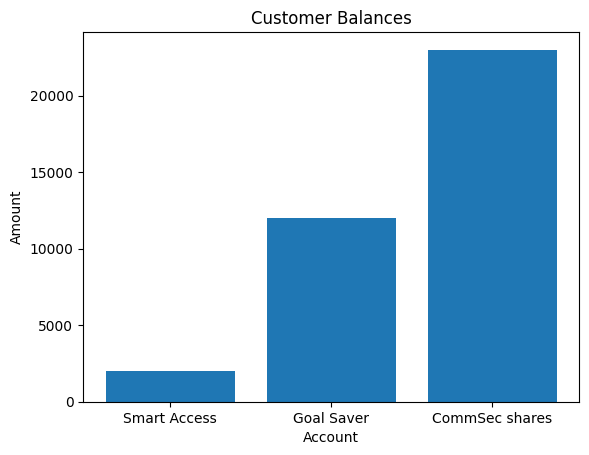

Tool Result: import matplotlib.pyplot as plt

balances = [2000.0, 12000.0, 23000.0]
names = ["Smart Access", "Goal Saver", "CommSec shares"]

plt.bar(names, balances)
plt.title("Customer Balances")
plt.xlabel("Account")
plt.ylabel("Amount")
plt.show()
[TextBlock(text="The key customer data extracted from the image includes:\n- Customer name: Justin\n- Balances:\n  - Smart Access: $2,000.00\n  - Goal Saver: $12,000.00\n  - CommSec shares: $23,000.00\n\nUsing the calculator tool, the average of all the customer's balances is $12,333.33.\n\nThe bar chart shows the customer's balances across the three accounts - Smart Access, Goal Saver, and CommSec shares. The x-axis labels the account names, and the y-axis shows the balance amounts.", type='text')]

Final Response: The key customer data extracted from the image includes:
- Customer name: Justin
- Balances:
  - Smart Access: $2,000.00
  - Goal Saver: $12,000.00
  - CommSec shares: $23,000.00

Using the calculator tool, the average of all 

"The key customer data extracted from the image includes:\n- Customer name: Justin\n- Balances:\n  - Smart Access: $2,000.00\n  - Goal Saver: $12,000.00\n  - CommSec shares: $23,000.00\n\nUsing the calculator tool, the average of all the customer's balances is $12,333.33.\n\nThe bar chart shows the customer's balances across the three accounts - Smart Access, Goal Saver, and CommSec shares. The x-axis labels the account names, and the y-axis shows the balance amounts."

In [32]:
prompt = f"1) Extract customer data from the textual information on the iphone.  Do not try to identify people's faces, just extract text.  Do not make up names or amounts.  2) Use the calculator tool to give the average of all their balances.  3) Make a bar chart to show customer balances with names and amounts.  Do not make up names or amounts."
chat_with_claude(prompt, base64_encoded_pngs[0])